# <font color = 'purple'> Análise de Sentimentos em Tweets sobre o ChatGPT com PySpark </font>

Análise de sentimento é realizado em textos para determinar se o que está sendo dito é positivo, negativo ou neutro.
Sendo útil para averiguar comentários a respeito de algum serviço ou produto, ou mesmo analisar textos em redes sociais.
Este projeto tem como objetivo realizar análise de sentimento sobre o ChatGPT, será utilizado pyspark, pandas, numpy, google translator, a ferramenta de análise de sentimentos chamada: Vader Sentiment Analysis e a biblioteca matplotlib para exibir o resultado em um gráfico.

O conjunto de dados utilizado pode ser encontrado em: https://www.kaggle.com/datasets/tariqsays/chatgpt-twitter-dataset

Como o conjunto de dados não possui as classificações para os tweets, teremos que utilizar uma ferramenta que não necessita de 
treinamento, por isso, escolhi utilizar VADER (Valence Aware Dictionary for sEntiment Reasoning), que utiliza dicionário léxico para realizar as análises de sentimento. E funciona bem em textos de redes socias.

Léxico significa - conjunto das palavras e expressões de uma língua

Além de utilizar um dicionário léxico, também realiza as análises baseados nestas 5 características:

Pontuação do texto <br>
Considera se o texto está em maiúsculo ou minuscúlo <br>
Considera os advérbios <br>
A palavra "but" (mas) em português <br>
Tri - grama de palavras negativas

Irei traduzir os tweets que não estão em inglês para o inglês

Como considera "but" e outras stop words, irei realizar a análise com e sem stop words para verificar se o resultado é semelhante ou diferente.

In [2]:
# Instalação do google translator
# !pip install googletrans==3.1.0a0

In [3]:
# nltk.download('all')

In [1]:
# Importações

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, concat_ws

import googletrans
from googletrans import Translator

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Ajustando variáveis de ambiente
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
# Criando o spark context
sc = SparkContext(appName = 'Projeto4-AnaliseSentimentoPySpark')

In [4]:
# Exibir logs apenas do tipo erro
sc.setLogLevel("Error")

In [5]:
# Criando a sessão spark
spSession = SparkSession.builder.master("local[1]").getOrCreate()

In [6]:
# Importando os dados
dados = (spSession.read
      .option("multiline", "true") # alguns registros estão em mais de uma linha
      .option("quote", '"') # informando que temos as aspas para separar o texto (q tem virgula dentro) para nao impactar o delimitador
      .option("header", "true") 
      .option("escape", '"') # separando caracteres especiais
      .csv('dados/chatgpt1.csv')
)

In [7]:
# O objeto "dados" é do tipo dataframe spark
type(dados)

pyspark.sql.dataframe.DataFrame

In [8]:
# Exibindo as colunas
dados.columns

['Datetime',
 'Tweet Id',
 'Text',
 'Username',
 'Permalink',
 'User',
 'Outlinks',
 'CountLinks',
 'ReplyCount',
 'RetweetCount',
 'LikeCount',
 'QuoteCount',
 'ConversationId',
 'Language',
 'Source',
 'Media',
 'QuotedTweet',
 'MentionedUsers',
 'hashtag',
 'hastag_counts']

In [9]:
# Exibindo o número de linhas
dados.count()

50001

In [11]:
# Vou converter para o pandas para poder manipular
pandasDF = dados.toPandas()


### Traduzir os textos que não estão em inglês para facilitar posteriormente na análise de sentimentos

In [12]:
# TEMOS 50001 LINHAS
len(pandasDF)

50001

In [13]:
pandasDF['Language'].unique()

array(['ja', 'en', 'de', 'tr', 'pl', 'fr', 'es', 'pt', 'lo', 'no', 'ca',
       'zh', 'qme', 'th', 'ne', 'ko', 'und', 'nl', 'fa', 'it', 'da', 'fi',
       'eu', 'hi', 'ar', 'sv', 'in', 'ru', 'qht', 'tl', 'hu', 'cs', 'uk',
       'iw', 'et', 'cy', 'bg', 'ht', 'el', 'vi', 'sl', 'kn', 'ro', 'lt',
       'ur', 'zxx', 'ml', 'mr', 'lv', 'gu', 'qam', 'is', 'ta', 'te', 'pa',
       'sd', 'am', 'sr', 'hy', 'or', 'bn'], dtype=object)

In [14]:
# 32076 estão em inglês
len(pandasDF[['Text','Language']].loc[pandasDF['Language'] == 'en'])

32076

In [15]:
# salvando em outro dataframe os textos diferentes de inglês
pandas_text = pandasDF[['Text','Language']].loc[pandasDF['Language'] != 'en']
pandas_text

,Text,Language
0,ChatGPTで遊ぶの忘れてた！！\n書類作るコード書いてみてほしいのと、\nどこまで思考整...,ja
2,"Schaut Euch an, was @fobizz @DianaKnodel alles...",de
4,"Profilinde vatan, Türkiye falan yazan bireyler...",tr
5,ChatGPT’nin bilinmeyen arka planı: Ucuz iş güc...,tr
12,最新コメント15件（01/22 22:45）\n\n【1月17日 登録記事】AzureでCh...,ja
...,...,...
49994,@FedeMoctezuma 5 cosas que puedes hacer con C...,es
49996,"#ChatGPT ist ein #Chatbot, der durch künstlich...",de
49997,@r8r Ich hab mal die AI dazu befragt (ChatGPT)...,de
49998,5 minuti di #chatGPT e ho capito che apprende ...,it


In [19]:
type(pandas_text)

pandas.core.frame.DataFrame

In [16]:
# Verificando se todos os idiomas estão no google translator
google_list = list(googletrans.LANGUAGES.keys())

In [17]:
language_list = [pandas_text.iloc[i][1] for i in range(len(pandas_text))] 
     

### Existem alguns que não estão no google translator, mas apenas 2 são idiomas, como podemos ver abaixo no significado

In [18]:
difference = list(set(language_list) - set(google_list))
difference

['in', 'qht', 'qam', 'qme', 'zxx', 'zh', 'und']

### significado de cada abreviação:

<br> und -> indeterminado </br>
<br> qht -> somente hashtags </br>
<br> zxx -> tweets com media ou card, sem texto </br>
<br> qam -> somente menção </br>
<br> zh -> alterar para zh-cn </br>
<br> in -> alterar para ms </br>
<br> qme -> media links </br>


In [19]:
quantidade_zh = len(pandas_text.loc[pandas_text['Language'] == 'zh'])
quantidade_in = len(pandas_text.loc[pandas_text['Language'] == 'in'])
print(f'Language "zh": {quantidade_zh}')
print(f'Language "in": {quantidade_in}')

Language "zh": 149
Language "in": 251


#### Irei excluir as linhas com "Language"  und, qht, zxx, qam, qme
#### Irei alterar as linhas com "Language"  zh e in

In [20]:
len(pandasDF.loc[(pandasDF['Language'] =='qme') | (pandasDF['Language'] =='und')  | (pandasDF['Language'] =='qht')  | (pandasDF['Language'] =='zxx') | (pandasDF['Language'] =='qam')])

917

In [21]:
pandasDF.drop(pandasDF.loc[(pandasDF['Language'] =='qme') | (pandasDF['Language'] =='und')  | (pandasDF['Language'] =='qht')  | (pandasDF['Language'] =='zxx') | (pandasDF['Language'] =='qam')].index, inplace = True)

In [22]:
len(pandasDF)

49084

In [23]:
pandasDF['Language'].loc[pandasDF['Language'] == 'zh'] = 'zh-cn'

In [24]:
pandasDF['Language'].loc[pandasDF['Language'] == 'in'] = 'ms'

In [25]:
quantidade_zh_cn = len(pandasDF.loc[pandasDF['Language'] == 'zh-cn'])
quantidade_ms = len(pandasDF.loc[pandasDF['Language'] == 'ms'])
print(f'Language "zh_cn": {quantidade_zh_cn}')
print(f'Language "ms": {quantidade_ms}')

Language "zh_cn": 149
Language "ms": 251


In [26]:
# atualizando a outra tabela
pandas_text = pandasDF[['Text','Language']].loc[pandasDF['Language'] != 'en']
pandas_text.head(10)

,Text,Language
0,ChatGPTで遊ぶの忘れてた！！\n書類作るコード書いてみてほしいのと、\nどこまで思考整...,ja
2,"Schaut Euch an, was @fobizz @DianaKnodel alles...",de
4,"Profilinde vatan, Türkiye falan yazan bireyler...",tr
5,ChatGPT’nin bilinmeyen arka planı: Ucuz iş güc...,tr
12,最新コメント15件（01/22 22:45）\n\n【1月17日 登録記事】AzureでCh...,ja
13,Są dobre i złe wieści na temat ChatGPT.\n\n✅ O...,pl
14,#ChatGPT wydaje na operację w chmurze 3 mln do...,pl
16,J'ai juste demander à l'IA chatGPT de faire un...,fr
17,"Google Presenta Sparrow, Su Inteligencia Artif...",es
24,"esse chatGPT é bonzão pra explicar código, tá ...",pt


In [27]:
# listando todas os idiomas
language_list = [pandas_text.iloc[i][1] for i in range(len(pandas_text))] 
     

#### Agora não temos diferenças

In [28]:
difference = list(set(language_list) - set(google_list))
difference

[]

In [29]:
# criar uma instância da classe Translator
translator = Translator()

#### Realizando a tradução para o inglês

##### Neste looping realizei a tradução, levou em torno de 40 minutos, por isso, salvei o resultado e estou importando pelo objeto "arquivo_traducoes"

In [34]:
#translations_list = []
#for item in range(len(pandas_text)):
#    translations = translator.translate(pandas_text.iloc[item][0], dest='en', src = language_list[item] )
#    translations_list.append(translations.text)    

In [35]:
#traducao_df = pd.DataFrame(translations_list)

Salvar o texto traduzido

In [36]:
#pandas_text['Traduzido'] = translations_list

In [37]:
#pandas_text['Traduzido']

### Exportando o resultado da tradução

In [38]:
#pandas_text.to_csv('dados/traducao_v2.csv', index = True)

In [39]:
#?pd.DataFrame.to_csv

### Importando arquivo com as traduções

In [30]:
arquivo_traducoes = pd.read_csv("dados/traducao_v2.csv", delimiter = ',', header = None, names = ["Text", "Language","Traduzido"], index_col = 0, skiprows = [0])

In [31]:
arquivo_traducoes

,Text,Language,Traduzido
0,ChatGPTで遊ぶの忘れてた！！\n書類作るコード書いてみてほしいのと、\nどこまで思考整...,ja,I forgot to play ChatGPT! !\nI want you to wri...
2,"Schaut Euch an, was @fobizz @DianaKnodel alles...",de,Check out what @fobizz @DianaKnodel brings to ...
4,"Profilinde vatan, Türkiye falan yazan bireyler...",tr,The first thing that individuals who write hom...
5,ChatGPT’nin bilinmeyen arka planı: Ucuz iş güc...,tr,The unknown background of ChatGPT: Cheap labor...
12,最新コメント15件（01/22 22:45）\n\n【1月17日 登録記事】AzureでCh...,ja,15 latest comments (01/22 22:45)\n\n[Article r...
...,...,...,...
49994,@FedeMoctezuma 5 cosas que puedes hacer con C...,es,@FedeMoctezuma 5 things you can do with ChatGP...
49996,"#ChatGPT ist ein #Chatbot, der durch künstlich...",de,#ChatGPT is a #chatbot that uses artificial in...
49997,@r8r Ich hab mal die AI dazu befragt (ChatGPT)...,de,@r8r I asked the AI ​​about it (ChatGPT) https...
49998,5 minuti di #chatGPT e ho capito che apprende ...,it,5 minutes of #chatGPT and I realized that he l...


In [32]:
# Criando uma cópia do dataframe pandas
pandasDF_V2 = pandasDF.copy()

In [33]:
len(pandasDF_V2)

49084

### Alterando os textos que não estão em inglês para os textos traduzidos

In [44]:
# pandasDF_V2['Text'].loc[pandasDF_V2['Language'] != 'en'] = pandas_text['Traduzido']

In [34]:
# Passando as traduções para os textos que não estão em inglês
pandasDF_V2['Text'].loc[pandasDF_V2['Language'] != 'en'] = arquivo_traducoes['Traduzido']

In [35]:
len(pandasDF_V2)

49084

In [36]:
# Filtrando apenas os Textos (Tweets)
pandasDF_V2_text = pandasDF_V2['Text']
pandasDF_V2_text = pd.DataFrame(pandasDF_V2_text)
pandasDF_V2_text

,Text
0,I forgot to play ChatGPT! !\nI want you to wri...
1,@AlexandrovnaIng Prohibition of ChatGPT has be...
2,Check out what @fobizz @DianaKnodel brings to ...
3,Bow down to chatGPT 🫡..... https://t.co/ENTSzi...
4,The first thing that individuals who write hom...
...,...
49996,#ChatGPT is a #chatbot that uses artificial in...
49997,@r8r I asked the AI ​​about it (ChatGPT) https...
49998,5 minutes of #chatGPT and I realized that he l...
49999,Portland Shop Uses ChatGPT To Tell Family Stor...


### Criando o DataFrame do Spark com os tweets, todos em inglês

In [37]:
spark_df = spSession.createDataFrame(pandasDF_V2_text)

### Realizando a limpeza dos tweets

Irei remover os links e RT (retweet) e @. Irei deixar os emoticons e pontuações.

In [38]:
tweet_v1 = spark_df.withColumn("Clean", F.regexp_replace("Text", "RT @[\w]*:", ""))
tweet_v2 = tweet_v1.withColumn("Clean", F.regexp_replace("Clean", "@[\w]*", ""))
tweet_final = tweet_v2.withColumn("Clean", F.regexp_replace("Clean", "https?://[A-Za-z0-9./]*", ""))

In [39]:
tweet_final.show(20)

+--------------------+--------------------+
|                Text|               Clean|
+--------------------+--------------------+
|I forgot to play ...|I forgot to play ...|
|@AlexandrovnaIng ...| Prohibition of C...|
|Check out what @f...|Check out what   ...|
|Bow down to chatG...|Bow down to chatG...|
|The first thing t...|The first thing t...|
|The unknown backg...|The unknown backg...|
|ChatGPT runs 10K ...|ChatGPT runs 10K ...|
|@SWENGDAD There i...| There is repetit...|
|I created a ficti...|I created a ficti...|
|It will look simi...|It will look simi...|
|If you ever playe...|If you ever playe...|
|AI will initiate ...|AI will initiate ...|
|15 latest comment...|15 latest comment...|
|There is good new...|There is good new...|
|#ChatGPT spends $...|#ChatGPT spends $...|
|🤯 #ChatGPT write...|🤯 #ChatGPT write...|
|I just asked the ...|I just asked the ...|
|Google Presents S...|Google Presents S...|
|Pay $42 per month...|Pay $42 per month...|
|Your own AI knowl...|Your own AI 

### Criando "tokenização" dos tweets, ou seja, separando o texto em tokens, particionando em palavras


### Aqui o Tokenizer irá separar pelo espaço em branco

In [41]:
# Criando a instância da classe Tokenizer do pyspark
tokenizer = Tokenizer(inputCol = 'Clean', outputCol='words')

# aplicando a transformaçao nos textos e gerando uma tabela com o resultado

df_tokenized = tokenizer.transform(tweet_final)

# Selecionando as colunas
df_tokenized.select("Clean", "words").show(5)    

+--------------------+--------------------+
|               Clean|               words|
+--------------------+--------------------+
|I forgot to play ...|[i, forgot, to, p...|
| Prohibition of C...|[, prohibition, o...|
|Check out what   ...|[check, out, what...|
|Bow down to chatG...|[bow, down, to, c...|
|The first thing t...|[the, first, thin...|
+--------------------+--------------------+
only showing top 5 rows



### Aqui irá remover stop word 

<b>por exemplo: os tokens da frase "my daughter's" eram: <i> my, daughter, s </i> </b>

<b> após a remoção das stop words, ficou apenas <i>"daughter" </i> </b>

In [42]:
remover = StopWordsRemover(inputCol="words", outputCol="tweet_no_stop_words")
result = remover.transform(df_tokenized).select("tweet_no_stop_words")

In [43]:
# essas são as stop words
remover.getStopWords()

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [44]:
# Mostrando o resultado
result.show(5)

+--------------------+
| tweet_no_stop_words|
+--------------------+
|[forgot, play, ch...|
|[, prohibition, c...|
|[check, , , bring...|
|[bow, chatgpt, 🫡...|
|[first, thing, in...|
+--------------------+
only showing top 5 rows



#### Aqui irei retirar os dados da coluna "tweet_no_stop_words" das listas, para posteriormente poder retirar as vírgulas (se não retirar ocorre erro quando for tentar retirar as vírgulas)

In [45]:
result2 = result.withColumn("tweet_no_stop_words", concat_ws(",", col("tweet_no_stop_words")))

In [46]:
result2.show(5)

+--------------------+
| tweet_no_stop_words|
+--------------------+
|forgot,play,chatg...|
|,prohibition,chat...|
|check,,,brings,sl...|
| bow,chatgpt,🫡.....|
|first,thing,indiv...|
+--------------------+
only showing top 5 rows



#### Agora substituir as vírgulas por espaço

In [47]:
result2 = result2.withColumn("tweet_no_stop_words", F.regexp_replace("tweet_no_stop_words",',',' '))

In [48]:
result2.show(5)

+--------------------+
| tweet_no_stop_words|
+--------------------+
|forgot play chatg...|
| prohibition chat...|
|check   brings sl...|
| bow chatgpt 🫡.....|
|first thing indiv...|
+--------------------+
only showing top 5 rows



#### Criando uma função para gerar o score do sentimento utilizando SentimentIntensityAnalyzer

Criando o objeto da classe SentimentIntensityAnalyzer. Depois atribuindo uma variável para receber o resultado do método "polarity_score" que retorna um dicionário informando se o texto é "negativo", "neutro", "positivo" e o "compound" que é a soma de todos os anteriores essa métrica vai de -1 a 1, sendo -1 negativo e 1 positivo


In [49]:
def scoreSentimentIntensity(texto):
    sentimentIntensity_object = SentimentIntensityAnalyzer()
    dict_sentiment = sentimentIntensity_object.polarity_scores(texto)
    return float(dict_sentiment['compound'])

#### Passando os dados para a função, gerou os scores

Aplicar a função usando "withColumn" <br>
udf - user defined function

In [51]:
udfSentimentIntensity = udf(scoreSentimentIntensity, FloatType())
df_SentimentScore = result2.withColumn('sentimentScore', udfSentimentIntensity('tweet_no_stop_words'))
df_SentimentScore.select('sentimentScore').show(5)

+--------------+
|sentimentScore|
+--------------+
|        0.7081|
|        0.4939|
|        0.2023|
|           0.0|
|        0.5083|
+--------------+
only showing top 5 rows



#### Gerando uma função para classificar os scores <br>
Será considerado um tweet <b>POSITIVO</b> se o score for <b>maior</b> que <b>0,05</b> <br>
Será considerado um tweet <b>NEUTRO</b> se o score estiver <b>entre -0,05 e 0,05 </b> <br>
Será considerado um tweet <b>NEGATIVO</b> se o score for <b>menor</b> que <b>-0,05</b>

In [52]:
def classifierSentiment(score):
    return 1 if score > 0.05 else (0 if -0.05 < score < 0.05 else -1)

In [53]:
udfSentiment = udf(classifierSentiment, IntegerType())
df_Class = df_SentimentScore.withColumn('sentiment', udfSentiment('sentimentScore'))
df_Class.select('sentimentScore','sentiment').show(5)

+--------------+---------+
|sentimentScore|sentiment|
+--------------+---------+
|        0.7081|        1|
|        0.4939|        1|
|        0.2023|        1|
|           0.0|        0|
|        0.5083|        1|
+--------------+---------+
only showing top 5 rows



In [54]:
sentimentos_resultado = df_Class.groupby('sentiment').count()

## Temos o seguinte resultado:

<b>POSITIVO:</b> 23576 tweets <br>
<b>NEUTRO:</b>   17271 tweets <br>
<b>NEGATIVO:</b>  8237

In [55]:
sentimentos_resultado = sentimentos_resultado.toPandas()

In [56]:
sentimentos_resultado

,sentiment,count
0,-1,8237
1,1,23576
2,0,17271


In [57]:
sentimentos_resultado['sentiment'] = np.where(sentimentos_resultado['sentiment'] == 1, "Positivo", np.where(sentimentos_resultado['sentiment'] == 0, "Neutro", "Negativo" ))

In [58]:
sentimentos_resultado.rename(columns = {'sentiment': 'Sentimento', 'count': 'Total'}, inplace = True)

In [59]:
sentimentos_resultado

,Sentimento,Total
0,Negativo,8237
1,Positivo,23576
2,Neutro,17271


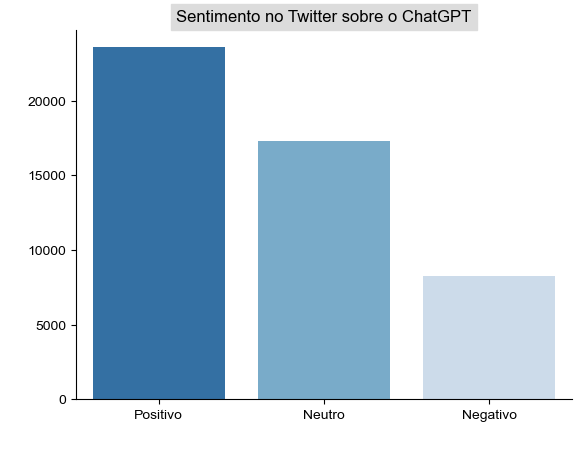

In [60]:
sns.barplot(data = sentimentos_resultado, x = 'Sentimento', y = 'Total', palette = 'Blues_r', order = ['Positivo','Neutro','Negativo'])
sns.set(style="whitegrid")
sns.despine()
plt.xlabel(' ')
plt.ylabel(' ')
title = plt.title('Sentimento no Twitter sobre o ChatGPT')
title.set_backgroundcolor('gainsboro')
plt.show()

# Sem remover as STOP WORDS

In [61]:
df_tokenized.show(5)

+--------------------+--------------------+--------------------+
|                Text|               Clean|               words|
+--------------------+--------------------+--------------------+
|I forgot to play ...|I forgot to play ...|[i, forgot, to, p...|
|@AlexandrovnaIng ...| Prohibition of C...|[, prohibition, o...|
|Check out what @f...|Check out what   ...|[check, out, what...|
|Bow down to chatG...|Bow down to chatG...|[bow, down, to, c...|
|The first thing t...|The first thing t...|[the, first, thin...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [62]:
df_tokenized_2 = df_tokenized.withColumn("tokens", concat_ws(",", col("words")))

In [63]:
df_tokenized_2 = df_tokenized_2.withColumn("tokens", F.regexp_replace("tokens",',',' '))

In [64]:
udfSentimentIntensity2 = udf(scoreSentimentIntensity, FloatType())
df_SentimentScore2 = df_tokenized_2.withColumn('sentimentScore', udfSentimentIntensity2('tokens'))
df_SentimentScore2.select('sentimentScore').show(5)

+--------------+
|sentimentScore|
+--------------+
|        0.5475|
|        0.4939|
|        0.2023|
|           0.0|
|        0.5083|
+--------------+
only showing top 5 rows



In [65]:
udfSentiment2 = udf(classifierSentiment, IntegerType())
df_Class2 = df_SentimentScore2.withColumn('sentiment', udfSentiment('sentimentScore'))
df_Class2.select('sentimentScore','sentiment').show(5)

+--------------+---------+
|sentimentScore|sentiment|
+--------------+---------+
|        0.5475|        1|
|        0.4939|        1|
|        0.2023|        1|
|           0.0|        0|
|        0.5083|        1|
+--------------+---------+
only showing top 5 rows



In [66]:
sentimentos_resultado2 = df_Class2.groupby('sentiment').count()

In [67]:
sentimentos_resultado2 = sentimentos_resultado2.toPandas()

In [68]:
sentimentos_resultado2

,sentiment,count
0,-1,9111
1,1,22920
2,0,17053


## Temos o seguinte resultado:

<b>POSITIVO:</b> 22920 tweets <br>
<b>NEUTRO:</b>   17053 tweets <br>
<b>NEGATIVO:</b>  9111 <br>

Tivemos um aumento de 874 tweets considerados negativos. <br>
Sendo que diminuiu 656 tweets considerados positivos <br>
e 218 a menos considerados neutros.



In [69]:
sentimentos_resultado2['sentiment'] = np.where(sentimentos_resultado2['sentiment'] == 1, "Positivo", np.where(sentimentos_resultado2['sentiment'] == 0, "Neutro", "Negativo" ))

In [70]:
sentimentos_resultado2.rename(columns = {'sentiment': 'Sentimento', 'count': 'Total'}, inplace = True)

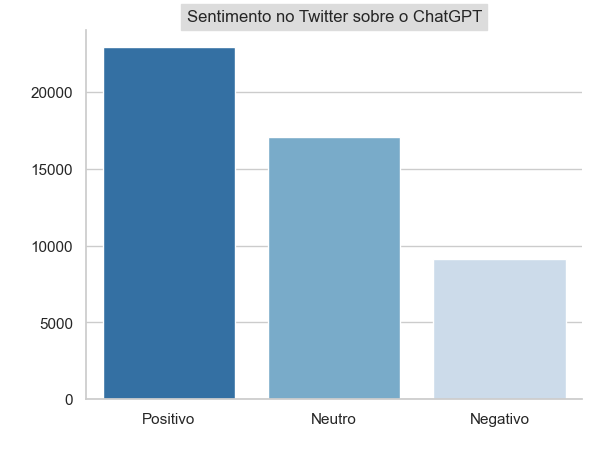

In [71]:
sns.barplot(data = sentimentos_resultado2, x = 'Sentimento', y = 'Total', palette = 'Blues_r', order = ['Positivo','Neutro','Negativo'])
sns.set(style="whitegrid")
sns.despine()
plt.xlabel(' ')
plt.ylabel(' ')
title = plt.title('Sentimento no Twitter sobre o ChatGPT')
title.set_backgroundcolor('gainsboro')
plt.show()